# Time Is Key: The Effect of Lockdown Measures on Covid-19 Rate of Infection

In [10]:
!pip install pint
!pip install modsimpy
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'


# import functions from the modsim.py module
from modsim import *

# Creating System Object and SIR Model
S = Susceptible; I = Infected; R = Recovered <br> Initial values are percentages of the population of the area in question

In [11]:
def make_system(beta, gamma, lockdown_time, population, t_end):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    lockdown_time: time it took for the city/state to lock down from first case
    population: number of people living in the area
    t_end: number of days of the outbreak
    
    returns: System object
    """
    #init = State(S=population-1, I=1, R=0)
    #init /= np.sum(init)
    
    # initialize percentages of Suceptable, Infected and Recovered
    init = State(S=.9999, I=.0001, R=0)
    
    t0 = 0

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, new_cases_per_day = TimeSeries(),
                  lockdown_time = lockdown_time, population=population, max_new_cases = 0)

# Defining the Differential Equations for the Transitions Between S, I, and R Populations
new_cases_per_day: Computes new cases from infected percentage <br>
max_new_cases: tracks the peak of the outbreak

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State (s, i, r)
    t: time
    system: System object
    
    returns: State (sir)
    """
    s, i, r = state
    #print(str(s) + " " + str(i) + " " + str(r))
    
    infected = system.beta * i * s
    recovered = system.gamma * i
    
    # Compute new cases as a number by multiplying daily infected percentage by population
    new_cases = round(infected*system.population)
    system.new_cases_per_day[t] = new_cases
    if (new_cases > system.max_new_cases):
        system.max_new_cases = new_cases
    #print (str(round(infected*population)) + " new cases")

    s -= infected
    i += infected - recovered
    r += recovered
    
    #print (str(s) + " " + str(i) + " " + str(r))
    
    return State(S=s, I=i, R=r)

# Simulating the outbreak from t0 to t_end
Once the lockdown_time is reached we will begin to reduce beta by .004 every day. This value was determined by repeatedly simulating the outbreak and choosing a value that best mirrored how the value changed in NYC.

# Assumptions:
1. Beta, Gamma, and therefore contact rate remain fixed prior to lockdown. However, this does not necessarily reflect the real world since infection rate fluxuates and eventually goes down naturally.
2. Beta decreases by a fixed amount every day following the implementation of lockdown measures.


In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init, t0, t_end = system.init, system.t0, system.t_end
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
        
    for t in linrange(t0, t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
        
        # Begin to reduce beta post lockdown
        if system.lockdown_time >= 0 and t > system.lockdown_time:
            system.beta = system.beta - .004 if system.beta > .004 else 0 
    
    return frame

In [5]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    # Total infected as a percentage = I + R = 1 - S
    return 1 - get_last_value(results.S)
    # This line would also work:
    #return get_last_value(results.I) + get_last_value(results.R)

In [6]:
def sweep_beta(beta_array, gamma, lockdown_time, population, t_end):
    """Sweep a range of values for beta.
    
    beta_array: array of beta values
    gamma: recovery rate
    
    returns: SweepSeries that maps from beta to total infected
    """
    sweep = SweepSeries()
    for beta in beta_array:
        system = make_system(beta, gamma, lockdown_time, population, t_end)
        results = run_simulation(system, update_func)
        sweep[beta] = round(calc_total_infected(results)*population)
    return sweep

In [7]:
def sweep_parameters(beta_array, gamma_array,lockdown_time, population, t_end):
    """Sweep a range of values for beta and gamma.
    
    beta_array: array of infection rates
    gamma_array: array of recovery rates
    
    returns: SweepFrame with one row for each beta
             and one column for each gamma
    """
    print("Sweeping through all beta values for every value of gamma.\nThis may take a minute, please wait...")

    frame = SweepFrame(columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(beta_array, gamma, lockdown_time, population, t_end)
    return frame

# Algorithmically determining beta, gamma, and contact number for NYC
Methodology: We loop through possible values for beta and gamma and run the model for each combination. This produces a table of simulation results. The columns correspond to different gamma values, the rows correspond to different beta values. The values are the predicted total cases in the city. We can then see which combination of parameters most closely mostches the actual total of NYC, 185,653.
# Parameter Initializtion
Lockdown time for NYC was 20 Days, we have 65 days of data from March 1st to compare to, and NYC's population is 8,399,000.

In [8]:
lockdown_time_NYC = 20
population_NYC = 8399000 #popultation of NYC
outbreak_length_NYC = 65

65

In [9]:
beta_array = [i for i in linspace(.1,.4,15)]
gamma_array = [i for i in linspace(.1,.4,15)]
frame = sweep_parameters(beta_array, gamma_array, lockdown_time_NYC, population_NYC, outbreak_length_NYC)

Sweeping through all beta values for every value of gamma.
This may take a minute, please wait...


,0.100000,0.121429,0.142857,0.164286,0.185714,0.207143,0.228571,0.250000,0.271429,0.292857,0.314286,0.335714,0.357143,0.378571,0.400000
0.100000,3530.0,2781.0,2298.0,1976.0,1755.0,1597.0,1482.0,1395.0,1328.0,1274.0,1231.0,1196.0,1166.0,1141.0,1120.0
0.121429,5875.0,4248.0,3261.0,2640.0,2233.0,1957.0,1762.0,1621.0,1514.0,1432.0,1368.0,1315.0,1272.0,1236.0,1206.0
0.142857,10748.0,7068.0,4981.0,3746.0,2983.0,2490.0,2159.0,1927.0,1759.0,1634.0,1537.0,1461.0,1399.0,1349.0,1306.0
0.164286,21716.0,12926.0,8286.0,5721.0,4233.0,3326.0,2748.0,2361.0,2092.0,1898.0,1753.0,1642.0,1554.0,1483.0,1425.0
0.185714,48379.0,26081.0,15144.0,9515.0,6464.0,4720.0,3670.0,3005.0,2564.0,2258.0,2037.0,1873.0,1747.0,1647.0,1567.0
0.207143,116737.0,57656.0,30444.0,17360.0,10742.0,7206.0,5207.0,4013.0,3262.0,2766.0,2423.0,2176.0,1992.0,1851.0,1740.0
0.228571,296555.0,137377.0,66860.0,34790.0,19572.0,11968.0,7947.0,5694.0,4357.0,3519.0,2968.0,2588.0,2315.0,2112.0,1956.0
0.250000,755680.0,342545.0,157662.0,75983.0,39114.0,21777.0,13192.0,8687.0,6180.0,4700.0,3777.0,3170.0,2753.0,2454.0,2231.0
0.271429,1776975.0,848401.0,386751.0,177557.0,85016.0,43416.0,23977.0,14413.0,9427.0,6666.0,5043.0,4034.0,3372.0,2918.0,2592.0
0.292857,3453119.0,1912981.0,933148.0,429065.0,197028.0,93951.0,47693.0,26169.0,15633.0,10166.0,7152.0,5386.0,4291.0,3574.0,3083.0


# Our Closest total case count was achieved with beta = 0.271429 an gamma = 0.164286
Those parameters gave us a contact rate of 0.271429/0.164286 = 1.652 and total cases = 177557. Now lets sweept through even more beta and gamma values within that range to get even closer to the actual

In [280]:
beta_array = [i for i in linspace(.2,.3,15)]
gamma_array = [i for i in linspace(.1,.2,15)]
frame = sweep_parameters(beta_array, gamma_array, lockdown_time_NYC, population_NYC, outbreak_length_NYC)

Sweeping through all beta values for every value of gamma.
This may take a minute, please wait...


,0.100000,0.107143,0.114286,0.121429,0.128571,0.135714,0.142857,0.150000,0.157143,0.164286,0.171429,0.178571,0.185714,0.192857,0.200000
0.200000,86393.0,68424.0,54571.0,43847.0,35508.0,28992.0,23874.0,19832.0,16622.0,14058.0,11998.0,10333.0,8979.0,7871.0,6958.0
0.207143,116737.0,91668.0,72446.0,57656.0,46229.0,37361.0,30444.0,25022.0,20749.0,17360.0,14659.0,12491.0,10742.0,9321.0,8160.0
0.214286,158668.0,123654.0,96921.0,76455.0,60732.0,48605.0,39210.0,31895.0,26170.0,21664.0,18098.0,15259.0,12984.0,11151.0,9664.0
0.221429,216623.0,167748.0,130535.0,102153.0,80450.0,63801.0,50977.0,41056.0,33343.0,27316.0,22579.0,18835.0,15858.0,13477.0,11559.0
0.228571,296555.0,228523.0,176765.0,137377.0,107361.0,84431.0,66860.0,53343.0,42899.0,34790.0,28460.0,23493.0,19572.0,16458.0,13969.0
0.235714,406241.0,312075.0,240314.0,185716.0,144180.0,112545.0,88398.0,69910.0,55703.0,44738.0,36233.0,29604.0,24406.0,20308.0,17056.0
0.242857,555443.0,426297.0,327407.0,251992.0,194599.0,150943.0,117705.0,92349.0,72952.0,58058.0,46573.0,37675.0,30745.0,25318.0,21043.0
0.250000,755680.0,580976.0,446030.0,342545.0,263553.0,203413.0,157662.0,122839.0,96285.0,75983.0,60406.0,48404.0,39114.0,31885.0,26229.0
0.257143,1019301.0,787472.0,605968.0,465435.0,357484.0,274995.0,212154.0,164339.0,127946.0,100205.0,79005.0,62748.0,50232.0,40551.0,33023.0
0.264286,1357470.0,1057652.0,818380.0,630413.0,484506.0,372221.0,286315.0,220822.0,170971.0,133027.0,104108.0,82016.0,65084.0,52056.0,41985.0


# We got it right on the nose! Beta = 0.235714 and gamma = 0.121429.
This gives us a contact number of 1.94 and total cases after 65 days = 185,716, compared to actual 185,653.

In [281]:
"""
Other possible values:

#beta = .261
#gamma = .15
#beta = 0.292857
#gamma = 0.185714
#beta = 0.271429
#gamma = 0.164286
#beta = 0.228571
#gamma = 0.114286
"""

beta = 0.235714
gamma = 0.121429


0.121429

In [282]:
def plot_new_cases (beta,gamma,system, name):
    plot(system.new_cases_per_day, label=name)
    decorate(xlabel='Time (Days)', ylabel='New Cases (Per Day)')

In [283]:
def generate_curve (beta, gamma, lockdown_time, population, name, t_end):
    system = make_system(beta, gamma, lockdown_time, population, t_end)
    results = run_simulation(system, update_func)
    total_infected = round(calc_total_infected(results)*population)
    plot_new_cases(beta,gamma,system, name)
    print("Locked Down After", system.lockdown_time, "days")
    print("Max New Cases", system.max_new_cases, "days")
    print("Contact Number After", t_end, "Days:", system.beta/system.gamma)
    print("Total cases", total_infected)
    return results

# Project NYC Curve and Compare to Actual

Locked Down After 20 days
Max New Cases 5352.0 days
Contact Number After 65 Days: 0.4917606173154671
Total cases 185711.0
Saving figure to file nyc20.pdf


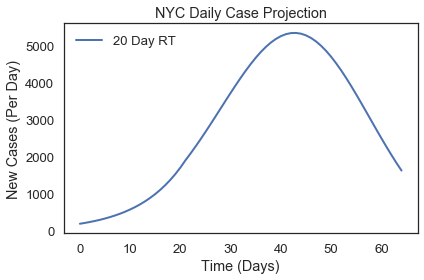

In [284]:
results = generate_curve(beta, gamma, lockdown_time_NYC, population_NYC, str(lockdown_time_NYC) + " Day RT", outbreak_length_NYC)
decorate(title="NYC Daily Case Projection")
savefig('nyc20.pdf')

# Not Bad! 
Here is the NYC department of health's data for reference:
https://www1.nyc.gov/site/doh/covid/covid-19-data.page
# Now let's plot S, I, and R to show how the populations change over time

In [285]:
def plotSIR (results, title):
    plot(results.S, label = "S")
    plot(results.I, label = "I")
    plot(results.R, label = "R")
    decorate(title=title,xlabel='Time (Days)', ylabel='Percentage of Population')
    percent_infected = calc_total_infected(results)*100
    print(str(round(percent_infected,2)) + "% of the population was infected")
 


2.21% of the population was infected
Saving figure to file SIR_NYC_20.pdf


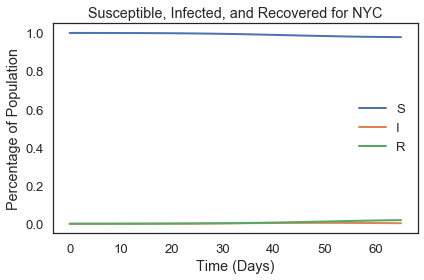

In [286]:
plotSIR(results,"Susceptible, Infected, and Recovered for NYC")
savefig('SIR_NYC_20.pdf')

# As you can see the lockdown was effective in "flattening the curve" and reducing the percentage of the population to become infected
Only 2.21 percent of the population became infected with a 20 day lockdown response time, however that translates into nearly 200,000 people. An earlier lockdown would reduce that percentage significantly.

# Now we will model NYC under various alternative response times for comparison

Locked Down After 0 days
Max New Cases 636.0 days
Contact Number After 160 Days: 0.0
Total cases 22274.0
Locked Down After 5 days
Max New Cases 1089.0 days
Contact Number After 160 Days: 0.0
Total cases 38777.0
Locked Down After 10 days
Max New Cases 1860.0 days
Contact Number After 160 Days: 0.0
Total cases 66878.0
Locked Down After 15 days
Max New Cases 3166.0 days
Contact Number After 160 Days: 0.0
Total cases 114428.0
Locked Down After 20 days
Max New Cases 5352.0 days
Contact Number After 160 Days: 0.0
Total cases 194042.0
Locked Down After 25 days
Max New Cases 8956.0 days
Contact Number After 160 Days: 0.0
Total cases 325025.0
Locked Down After 30 days
Max New Cases 14734.0 days
Contact Number After 160 Days: 0.0
Total cases 534495.0
Locked Down After 35 days
Max New Cases 23620.0 days
Contact Number After 160 Days: 0.0
Total cases 855001.0
Locked Down After 40 days
Max New Cases 36469.0 days
Contact Number After 160 Days: 0.0
Total cases 1314538.0
Locked Down After 45 days
Max 

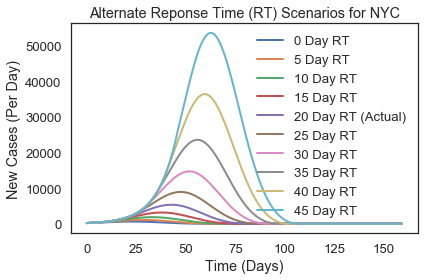

In [287]:
lockdown_array = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
results_array = []
t_end = 160
for lockdown in lockdown_array:
    label = str(lockdown) + " Day RT"
    if lockdown == 20:
        label += " (Actual)"
    results = generate_curve(beta, gamma, lockdown, population_NYC, label, t_end)
    results_array.append(results)
decorate(title = "Alternate Reponse Time (RT) Scenarios for NYC",xlabel='Time (Days)', ylabel='New Cases (Per Day)')
savefig('alternate_scenarios_nyc.pdf')

# In order to demonstrate how drastically response time affects infection rate let's plot S, I, and R for RT = 0 and RT = 45

0.27% of the population was infected
Saving figure to file SIR_RT_0.pdf


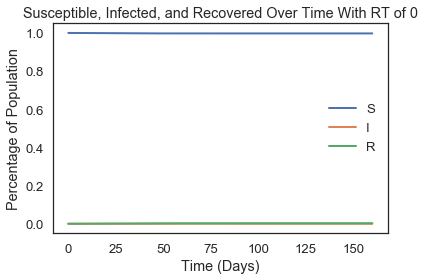

In [288]:
plotSIR(results_array[0],"Susceptible, Infected, and Recovered Over Time With RT of 0")
savefig("SIR_RT_0.pdf")

22.84% of the population was infected
Saving figure to file SIR_RT_45.pdf


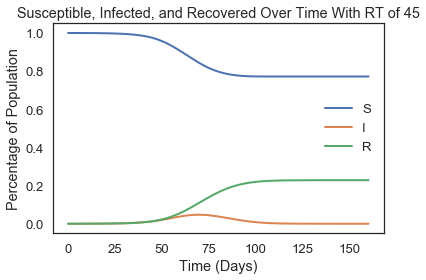

In [289]:
plotSIR(results_array[len(lockdown_array)-1],"Susceptible, Infected, and Recovered Over Time With RT of " + str(lockdown_array[len(lockdown_array)-1]))
savefig("SIR_RT_45.pdf")

# As you can see there is a huge difference
### RT = 0 --> .27% of the population being infected = 22,274 cases
### RT = 45 --> 22.84% of the population being infected = 1,917,930 cases
# Worst Case Scenario: No Lockdown
Let's see what happens if NYC were to stay open and allow the virus to run wild. Note, this is assuming contact rate stays constant, but in reality it would likely change naturally due to people's behavior changing.

Locked Down After -1 days
Max New Cases 167535.0 days
Contact Number After 175 Days: 1.9411672664684714
Total cases 6604914.0
Saving figure to file NYC_no_lockdown.pdf


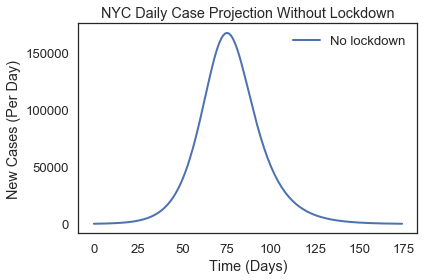

In [290]:
results = generate_curve(beta, gamma, -1, population_NYC, "No lockdown", 175)
decorate(title="NYC Daily Case Projection Without Lockdown")
savefig('NYC_no_lockdown.pdf')

78.64% of the population was infected
Saving figure to file NYC_no_lockdown_SIR.pdf


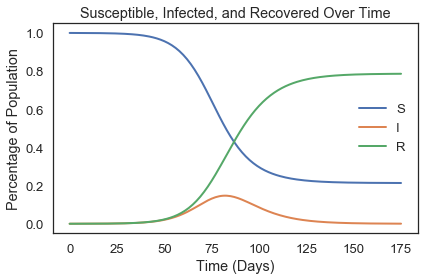

In [291]:
plotSIR(results,"Susceptible, Infected, and Recovered Over Time")
savefig('NYC_no_lockdown_SIR.pdf')

# As you can see, it would be catastrophic to not lock down
78.64% of the population were infected which translates into 6,604,914 cases of Covid-19. To make matters worse, at the peak of the outbreak (around 80 days in) roughly 20% of the population were infected simulataneously. This would mean over a million people would be sick at the same time, a scenario that would certainly overwhelm the healthcare capactiy of the city.

# Testing the model on other countries

This will illuminate the limitations of our model. Our model is very geared towards NYC and cannot predict other countries/cities well. The primary reason it fails for other countries is because population density is not taken into account. New York City is an extremely dense population which affects the contact rate. In order for this to work for other places we would have to research their contact rates, and consider variables such as population density and culture.

In [292]:
lockdown_time_NZ = 4
population_NZ = 4886000 

lockdown_time_Germ = 15
population_Germ = 83020000

lockdown_time_Italy = 16
population_Italy = 60360000

lockdown_time_UK = 23
population_UK = 66650000

66650000

Locked Down After 20 days
Max New Cases 5352.0 days
Contact Number After 100 Days: 0.0
Total cases 194042.0
Locked Down After 4 days
Max New Cases 569.0 days
Contact Number After 100 Days: 0.0
Total cases 20207.0
Locked Down After 15 days
Max New Cases 31293.0 days
Contact Number After 100 Days: 0.0
Total cases 1131064.0
Locked Down After 16 days
Max New Cases 25288.0 days
Contact Number After 100 Days: 0.0
Total cases 914678.0
Locked Down After 23 days
Max New Cases 57921.0 days
Contact Number After 100 Days: 0.0
Total cases 2102140.0


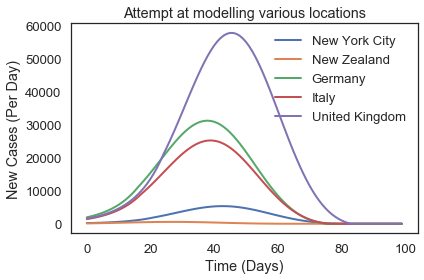

In [293]:
generate_curve(beta, gamma, lockdown_time_NYC, population_NYC, "New York City", 100)
generate_curve(beta, gamma, lockdown_time_NZ, population_NZ, "New Zealand",100)
generate_curve(beta, gamma, lockdown_time_Germ, population_Germ, "Germany",100)
generate_curve(beta, gamma, lockdown_time_Italy, population_Italy, "Italy",100)
generate_curve(beta, gamma, lockdown_time_UK, population_UK, "United Kingdom",100)
decorate(title="Attempt at modelling various locations")

# As you can see our model is very innaccurate for everyone except for New York and New Zealand
Our initial goal to create a general model for coronavirus was unsuccessful and incomplete. In the future we'd like to add parameters that quantify factors such as population density and infection vectors such as public transit.


# Finally we will demonstrate the relationship between the contact number (beta/gamma) and the percentage of the population that becomes infected
The contact numbers on the x-axis correspond to the INITIAL contact number values before lockdown at day 20

In [294]:
def plot_sweep_frame(frame):
    """Plot the values from a SweepFrame.
    
    For each (beta, gamma), compute the contact number,
    beta/gamma
    
    frame: SweepFrame with one row per beta, one column per gamma
    """
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            frac_infected = column[beta]/population_NYC
            plot(beta/gamma, frac_infected, 'ro')

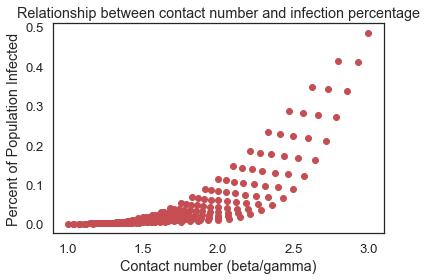

In [295]:
plot_sweep_frame(frame)

decorate(title="Relationship between contact number and infection percentage",xlabel='Contact number (beta/gamma)',
         ylabel='Percent of Population Infected')

